In [1]:
# !pip install tensorflow
# !pip install matplotlib
# !pip install numpy
# !pip install tensorflow_hub
#jak ma problem z pakietami to tą komórkę odpalić, jupyter może nie mieć zainstalowanych modułów mimo tego, że na kompie normalnie są

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
from pathlib import Path
#generic pies
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

#moje fotki, sami musicie sobie path ustawić
#content_path = r'C:\Users\jacek\OneDrive\Pulpit\studyja\2st\3sem\artistic-style-transfer\imgs\500_F_139696027_EFLchVwpe8slFsnrzPtjWolLLCPXwd41.jpg'

# spoko

style_path = Path("../imgs/costam.jpg")

content_path = Path('../imgs/freja.jpg')

In [6]:
content_path

PosixPath('../imgs/freja.jpg')

In [7]:
def load_img(path_to_img):
  max_dim = 512

  img = tf.io.read_file(str(path_to_img))
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

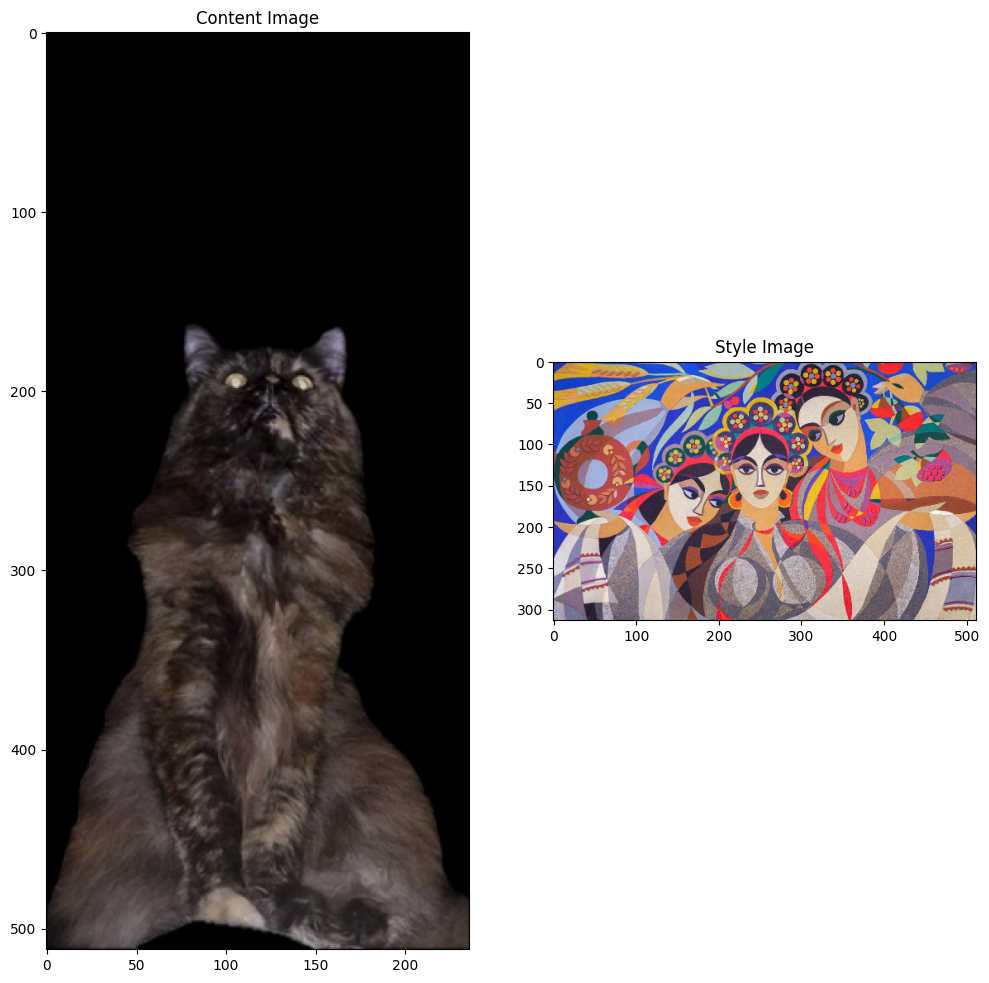

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

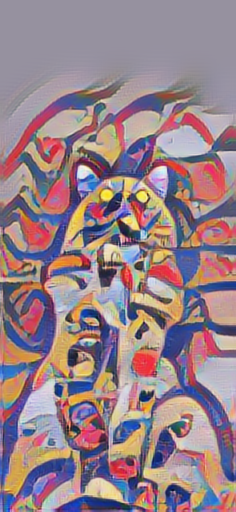

In [10]:
import tensorflow_hub as hub    #tutaj sam hub robi
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [11]:
#teraz "nasz" algorytm - vgg19 to rodzaj sieci, imo można potem popróbować z różnymi
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0] #rozpoznaje co na zdjeciu z psiakiem
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Egyptian_cat', np.float32(0.052157067)),
 ('Chesapeake_Bay_retriever', np.float32(0.04467542)),
 ('plastic_bag', np.float32(0.032705925)),
 ('cocker_spaniel', np.float32(0.029832125)),
 ('tabby', np.float32(0.028942786))]

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') #wypisuje warstwy jakie mamy

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
content_layers = ['block5_conv2'] #ustawia te ktore chcemy uzyc

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/Users/sdzol/Repozytoria/artistic-style-transfer/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 313, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 313, 512, 64)
  min:  0.0
  max:  817.9465
  mean:  33.864887

block2_conv1
  shape:  (1, 156, 256, 128)
  min:  0.0
  max:  5650.477
  mean:  191.5645

block3_conv1
  shape:  (1, 78, 128, 256)
  min:  0.0
  max:  9025.844
  mean:  239.7423

block4_conv1
  shape:  (1, 39, 64, 512)
  min:  0.0
  max:  22703.771
  mean:  858.76685

block5_conv1
  shape:  (1, 19, 32, 512)
  min:  0.0
  max:  3978.0645
  mean:  64.68668



In [ ]:
def gram_matrix(input_tensor): #funkcja obliczajaca styl jako macierz Grama, bardzo brzydki wzór na to jest. ok
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations) #SĄ DWIE MACIERZE GRAMA, STYLU I POTEM JEST MACIERZ WYGENEROWANEGO OBRAZU -> MOŻNA JE PRZEDSTAWIĆ JAKO MAPĘ CIEPŁA I PORÓWNAĆ FAJNIE
                                #MOZNA TEZ ZAPISAC JAKIES W TRAKCIE NAUKI, TAKI PROGRESS POKAZAĆ

In [18]:
class StyleContentModel(tf.keras.models.Model): #model zwracający tensor ze stylem i z treścią
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image)) #macierze grama ze stylem + zawartość warstw

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

/Users/sdzol/Repozytoria/artistic-style-transfer/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 512, 236, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00039603634
    max:  63311.992
    mean:  498.44107

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  55171.004
    mean:  11145.162

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  408308.8
    mean:  7819.928

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2947589.5
    mean:  147207.17

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  69259.016
    mean:  791.5831

Contents:
   block5_conv2
    shape:  (1, 32, 14, 512)
    min:  0.0
    max:  1190.5187
    mean:  9.389289


In [20]:
style_targets = extractor(style_image)['style'] #bo generalnie to obliczamy stratę obraz - styl jako błąd średniokwadratowy i chcemy zminimalizować to
content_targets = extractor(content_image)['content']

/Users/sdzol/Repozytoria/artistic-style-transfer/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 313, 512, 3))
  warnings.warn(msg)


In [21]:
image = tf.Variable(content_image) #obraz do optymalizacji - stylowania

In [22]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0) # normalizuje piksele na 0-1

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #optymalizator, polacaja adam albo lbfgs

In [24]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):    #daje stratę obraz - styl
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss    #TUTAJ BARTKU RÓŻNE PARAMETRY MOŻNA USTAWIAĆ, ŻEBY ZOBACZYĆ JAKIE EFEKTY DAJE - np style_loss*0.6 + content_loss*0.4
    return loss

In [26]:
@tf.function()
def train_step(image): #aktualizacja obrazu -> nałożenie stylu
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

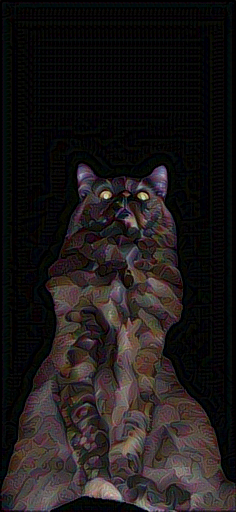

In [27]:
train_step(image)   #test czy działa - im więcej stepów tym bardziej styl nałożony
train_step(image)
train_step(image)
tensor_to_image(image)

In [28]:
from PIL import Image
def save_image(tensor, epoch):
    image_pil = tensor_to_image(tensor)
    image_pil.save(f"./efekt/obraz_epoka_{epoch}.jpg")

### UWAGA - to zapisuje obrazek co epoke, wiec albo se to zakomentuj albo zrób mało epok bo Cie zmiecie z planszy


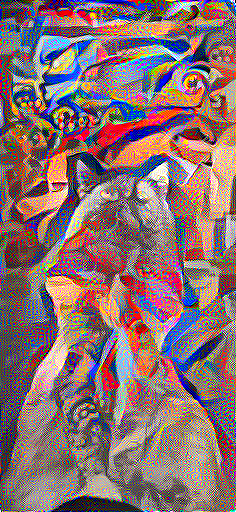

Train step: 60000
Total time: 30639.2


In [ ]:
import time         #teraz robi optymalizację dłużej, dając obraz końcowy - ten co przy tf hubie, ale trochę rozpikselizowany cn.
start = time.time() #długo się robi dość, ale to można zmniejszyć ilość epok / stepów na epokę

epochs = 50
steps_per_epoch = 1200
loss_arr = []
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    loss = train_step(image)
    loss_arr.append(loss.numpy())
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  save_image(image,n) #O tu jest zapisywanie obrazka

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [30]:
loss_arr

[np.float32(671347500.0),
 np.float32(509824300.0),
 np.float32(402889800.0),
 np.float32(336148770.0),
 np.float32(300430400.0),
 np.float32(280174270.0),
 np.float32(262413070.0),
 np.float32(244547380.0),
 np.float32(227734100.0),
 np.float32(212860240.0),
 np.float32(199721580.0),
 np.float32(188303970.0),
 np.float32(178616370.0),
 np.float32(170582100.0),
 np.float32(163901180.0),
 np.float32(158133460.0),
 np.float32(152816060.0),
 np.float32(147653570.0),
 np.float32(142580180.0),
 np.float32(137687740.0),
 np.float32(132974250.0),
 np.float32(128501300.0),
 np.float32(124196480.0),
 np.float32(120046100.0),
 np.float32(116063910.0),
 np.float32(112277416.0),
 np.float32(108700056.0),
 np.float32(105356480.0),
 np.float32(102198890.0),
 np.float32(99240776.0),
 np.float32(96444420.0),
 np.float32(93791630.0),
 np.float32(91325390.0),
 np.float32(89045960.0),
 np.float32(86958264.0),
 np.float32(85037610.0),
 np.float32(83272820.0),
 np.float32(81636500.0),
 np.float32(80122170.

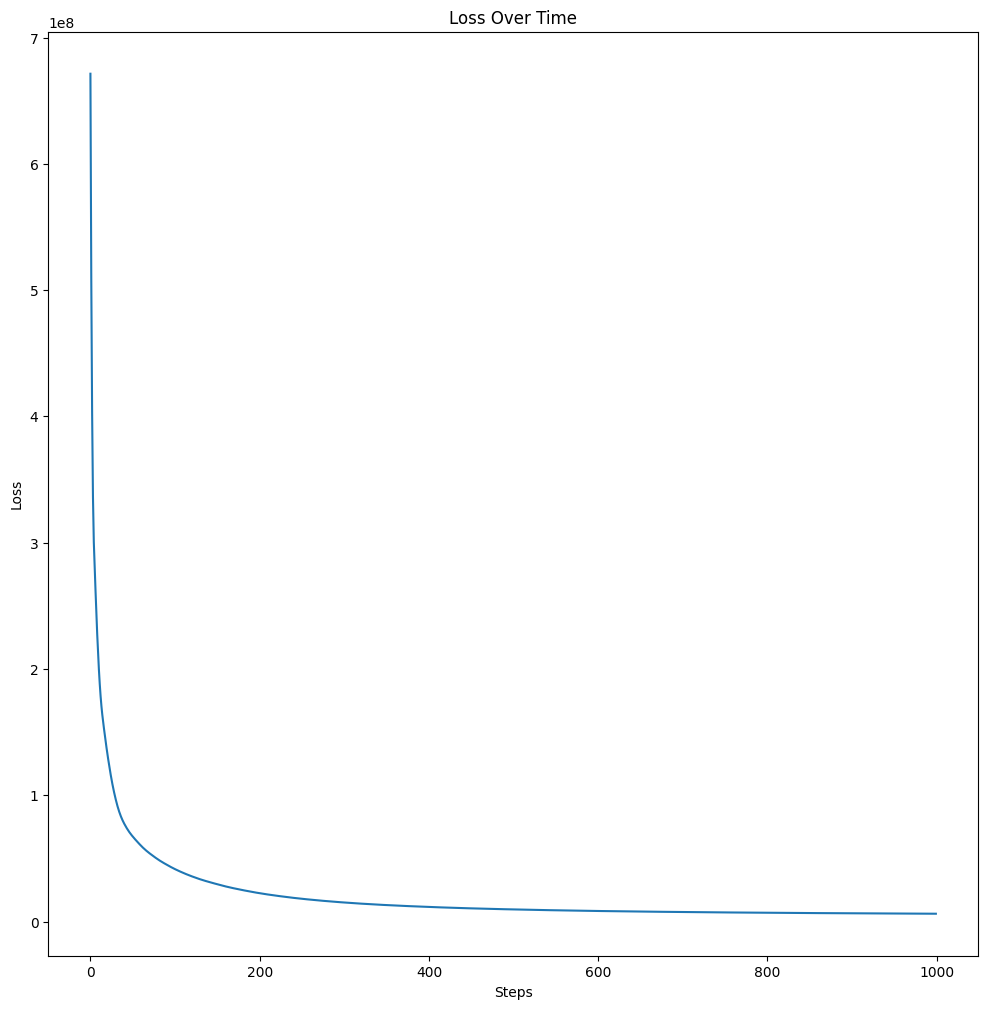

In [44]:
plt.plot(loss_arr[:1000])
plt.title("Loss Over Time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [32]:
def high_pass_x_y(image):   #tutaj robimy tak, że usuwamy duże częstotliwości z obrazu
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

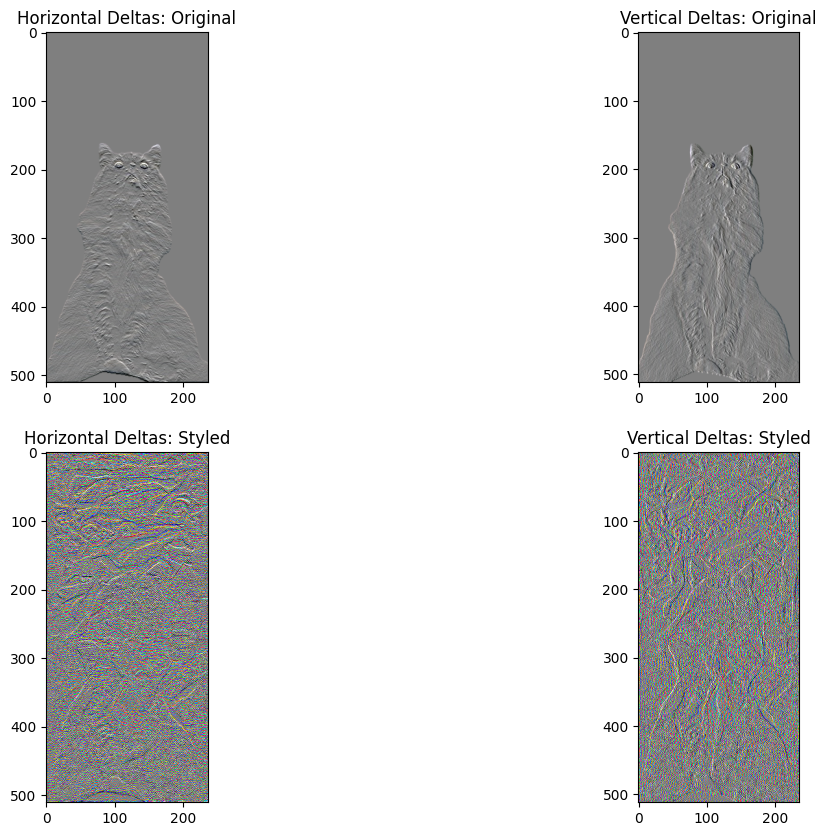

In [33]:
x_deltas, y_deltas = high_pass_x_y(content_image)   #tu widać te częstotliwości, not cool generalnie

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

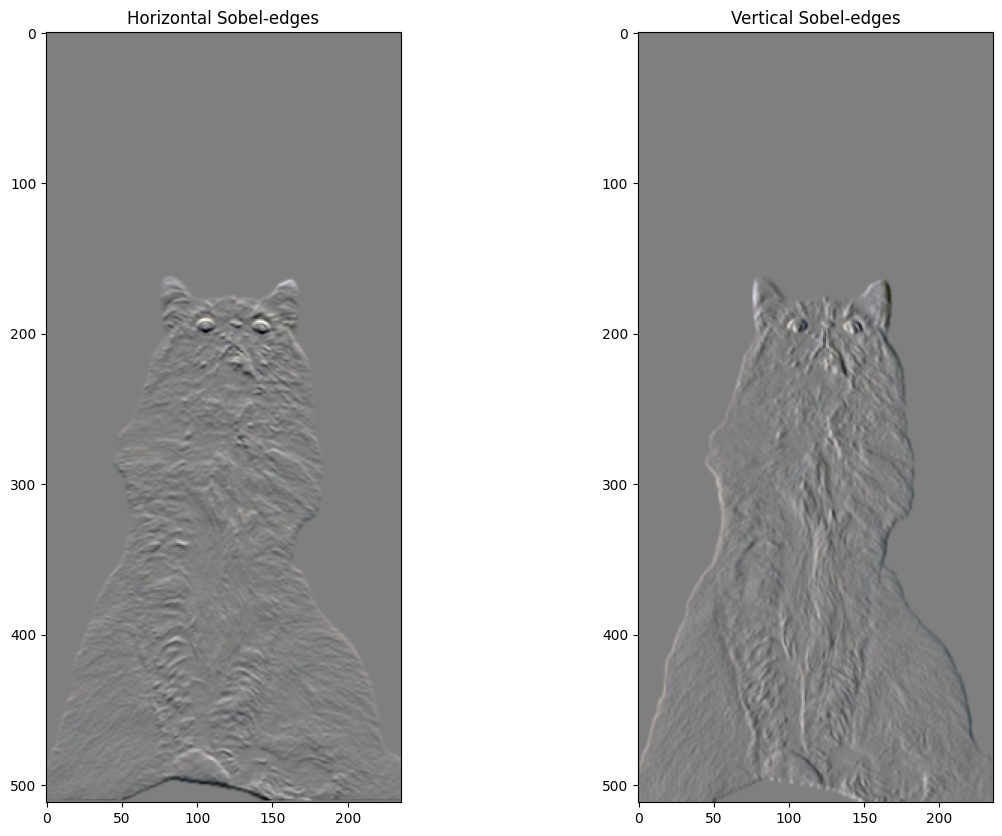

In [34]:
plt.figure(figsize=(14, 10))    #filtr sobela też da info o krawędziach

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [35]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [36]:
total_variation_loss(image).numpy()

np.float32(227748.12)

In [37]:
tf.image.total_variation(image).numpy()

array([227748.12], dtype=float32)

In [38]:
total_variation_weight=30 #na nowo optymalizuje

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02)  #dodać trzeba było, bo inaczej krzyczy że reusujemy optimizer- tego nie można robić xd


@tf.function()  #teraz trening bierze pod uwagę też te częstotliwości
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [40]:
image = tf.Variable(content_image)

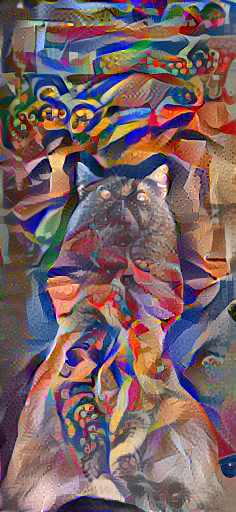

Train step: 5000
Total time: 2514.8


In [41]:
import time #pełniejszy obraz wychodzi, generalnie ładniej
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [42]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)